# Example for building an activity prediction model for the kinase ABL1

In [1]:
import pandas as pd
import numpy as np

from rdkit import Chem, DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import recall_score, cohen_kappa_score, roc_auc_score

### Helper functions

In [2]:
class FP:
    """
    Molecular fingerprint class that packs fingerprints in pandas df

    Parameters
    ----------
    fp : np.array
        Features stored in numpy array
    """
    def __init__(self, fp):
        self.fp = fp
    def __str__(self):
        return "%d bit FP" % len(self.fp)
    def __len__(self):
        return len(self.fp)

def get_fp(mol):
    """
    Generate concatenated connectivity- and feature-based RDKit Morgan fingerprint
    with fixed length and radius
    
    Parameters
    ----------
    mol : ROMol
        Input molecule
        
    Returns
    -------
    ML.FP
        Fingerprint (feature) object
    """
    info = {}
    arr = np.zeros((1,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=4096,
                                               useFeatures=False, bitInfo=info)
    DataStructs.ConvertToNumpyArray(fp, arr)
    arr = np.array([len(info[x]) if x in info else 0 for x in range(4096)])
    
    info2 = {}
    arr2 = np.zeros((1,))
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=4096,
                                                useFeatures=True, bitInfo=info2)
    DataStructs.ConvertToNumpyArray(fp2, arr2)
    arr2 = np.array([len(info2[x]) if x in info2 else 0 for x in range(4096)])
    
    fp_out = np.concatenate([arr, arr2])
    return FP(fp_out)

In [3]:
def get_binary_class(x, threshold=6.3):
    """
    For binarization of (pIC50) data. 6.3 corresponds to 500 nM
    """
    if np.isnan(x):
        return None
    elif x < threshold:
        return 0
    else:
        return 1

### Data preparation

In [4]:
df = pd.read_csv("ABL1.csv", index_col=0)

In [5]:
df.head()

,ABL1,smiles
0,5.599999,Brc1ccc2cnc(Nc3ccncn3)cc2c1
1,6.199998,Brc1cnc2[nH]cc(-c3ccccc3)c2c1
2,6.199998,C#Cc1cc2c(cc1OC)-c1[nH]nc(-c3ccc(C#N)nc3)c1C2
3,5.539102,C#Cc1cccc(Nc2ncnc3cc(OC)c(OCCCCCCC(=O)NO)cc23)c1
4,5.562959,C#Cc1cccc(Nc2ncnc3ccc(OCCCCNCCS(C)(=O)=O)cc23)c1


In [6]:
df['ABL1'] = df['ABL1'].astype(float)

Remove lines without compound information (SMILES)

In [7]:
df = df[~df.smiles.isnull()]

Build ROMol objects

In [8]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles')

Remove compounds where molecule object construction failed

In [9]:
df = df[~df.ROMol.isnull()]

Remove salts and recreate SMILES

In [10]:
PandasTools.RemoveSaltsFromFrame(df)
df['smiles'] = df['ROMol'].map(Chem.MolToSmiles)

In [11]:
df.shape

(2323, 3)

,ABL1,smiles,ROMol
0,5.599999,Brc1ccc2cnc(Nc3ccncn3)cc2c1,
1,6.199998,Brc1cnc2[nH]cc(-c3ccccc3)c2c1,

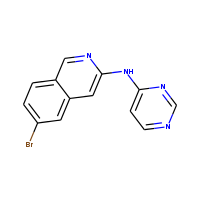
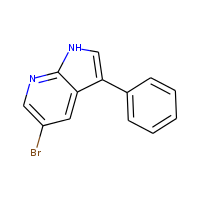

In [12]:
df.head(2)

Calculate fingerprints and store in data frame

In [13]:
df['fp'] = df.apply(lambda x: get_fp(x['ROMol']), axis=1)

### Generation of machine learning models

Define X variable (fingerprint data)

In [14]:
X = np.array([x.fp for x in df.fp])

In [15]:
X.shape

(2323, 8192)

Extract target values (y) form data frame and binarize at pIC50 = 6.3

In [16]:
y = np.array([get_binary_class(yi, threshold=6.3) for yi in df['ABL1'].values])

In [17]:
y.shape

(2323,)

Count actives in data set

In [18]:
sum(y)

621

### Validation: 5-fold cross-validation of random forest classifier

In [19]:
# Create index arrays for 5-fold cross-validation split
kf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=123)

# Initialize variables
sens     = np.array([])
spec     = np.array([])
mean_auc = np.array([])
kappa    = np.array([])

for train, test in kf:
    # Split data to training and test set
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]    

    # Random undersampling of training set
    US = RandomUnderSampler(ratio=1., replacement=False)
    X_train, y_train = US.fit_sample(X_train, y_train)
    
    # Random undersampling of test set
    US = RandomUnderSampler(ratio=1., replacement=False)
    X_test, y_test = US.fit_sample(X_test, y_test)
    
    # Training of random forest classifier
    clf = RandomForestClassifier(n_estimators=2500, max_features='log2',
                                 class_weight='auto', n_jobs=1)
    clf.fit(X_train, y_train)
    
    # Prediction of test set
    y_pred       = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test).T[1]
    
    # Saving validation parameters
    # Criteria: AUC, sensitiviy, specificity and kappa
    sens = np.append(sens, recall_score(y_test, y_pred, pos_label=1))
    spec = np.append(spec, recall_score(y_test, y_pred, pos_label=0))
    mean_auc = np.append(mean_auc, roc_auc_score(y_test, y_pred_proba))
    kappa = np.append(kappa, cohen_kappa_score(y_test, y_pred))

Results of 5-fold cross-validation

In [20]:
print 'AUC:\t\t%.2f +/- %.2f' % (mean_auc.mean(), mean_auc.std())
print 'Sensitivity:\t%.2f +/- %.2f' % (sens.mean(), sens.std())
print 'Specificity:\t%.2f +/- %.2f' % (spec.mean(), spec.std())
print 'Kappa:\t\t%.2f +/- %.2f' % (kappa.mean(), kappa.std())

AUC:		0.92 +/- 0.02
Sensitivity:	0.78 +/- 0.03
Specificity:	0.88 +/- 0.03
Kappa:		0.66 +/- 0.05


Copyright (C) 2016 by Benjamin Merget, BioMed X Innovation Center